In [157]:
import gdstk
import numpy as np
import matplotlib.pyplot as plt
from skimage.draw import polygon

In [158]:
lib = gdstk.read_gds("C:/Users/USER/Documents/Phd/Test_Patterns-20260102T051200Z-3-001/Test_Patterns/pattern_3.gds") #Load gds file
top_cell = lib.top_level()[0] #Load top cell
print("Top cell name: ",top_cell.name)

Top cell name:  top


In [159]:
#extract polygons
polygons = top_cell.get_polygons() #list where each element is a Nx2 numpr array of vertices
print("Number of polygons:", len(polygons))

Number of polygons: 4


In [160]:
#polygons by layer and dataype
MASK_LAYER = 1
MASK_DATATYPE = 0

mask_polys = []

for poly in polygons:
    # gdstk polygons store layer & datatype in attributes
    if poly.layer == MASK_LAYER and poly.datatype == MASK_DATATYPE:
        mask_polys.append(poly)

print("Mask polygons found:", len(mask_polys))

Mask polygons found: 4


In [161]:
#Define Resolution
pixel_size_nm = 1.0  # 1px = 1nm
scale_factor = 1000.0 / pixel_size_nm  # Conversion from um to px

#Bounding Box
bbox = top_cell.bounding_box()
min_x_um, min_y_um = bbox[0]
max_x_um, max_y_um = bbox[1]

width_um = max_x_um - min_x_um
height_um = max_y_um - min_y_um

print("Layout Dimensions: ",width_um,"um x ",height_um," um")
print("Layout Origin: ",min_x_um, min_y_um)

#Image Size
img_width = int(np.ceil(round(width_um,5) * scale_factor))
img_height = int(np.ceil(round(height_um,5) * scale_factor))

print("Rasterized Image Size: ",img_width," x ",img_height," pixels")

Layout Dimensions:  0.5 um x  0.25  um
Layout Origin:  0.0 0.0
Rasterized Image Size:  500  x  250  pixels


Rasterizing  4  polygons...


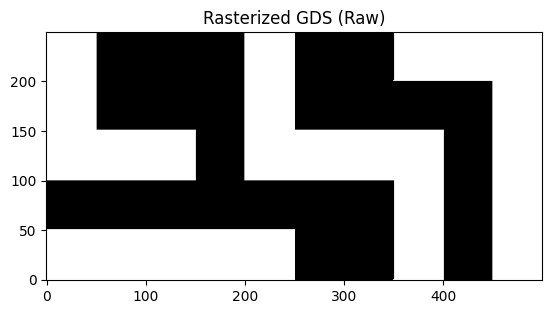

In [162]:
#Blank canvas (0 = Dark)
raw_mask = np.zeros((img_height, img_width), dtype=np.float32)

#Coordinates fetch for the specific layer directly
draw_polys = mask_polys
print("Rasterizing ",len(draw_polys)," polygons...")

for poly in draw_polys:
    #Coordinates shift so the design starts at 0,0 and scale coordinates from um to px
    poly_shifted = (poly.points - [min_x_um, min_y_um]) * scale_factor
    #Row (Y) and column (X) indices for the polygon
    rr, cc = polygon(poly_shifted[:, 1], poly_shifted[:, 0], shape=raw_mask.shape)
    #Polygon fill with 1.0 (White/Transparent)
    raw_mask[rr, cc] = 1.0

#Plotting the raw rasterization
plt.imshow(raw_mask, origin='lower', cmap='gray')
plt.title("Rasterized GDS (Raw)")
plt.show()

Final Simulation Grid:  1024 x 1024  pixels


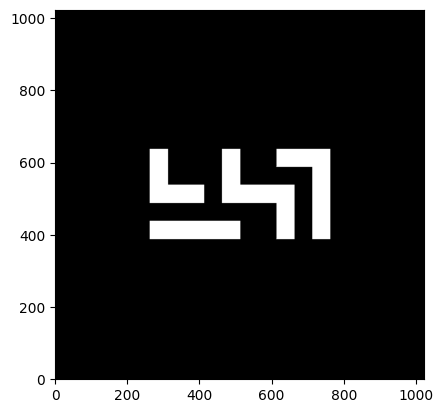

In [163]:
#Define Simulation window
N_sim = 1024 #1024 px = 1.024 um

if img_width > N_sim or img_height > N_sim:
    print("WARNING: GDS is larger than the simulation window!")
    N_sim = 2048 #next size if needed
    print("Increased grid size to ",N_sim)

#Final simulation mask
mask = np.zeros((N_sim, N_sim), dtype=np.float32)

#offsets to center the image
start_y = (N_sim - img_height) // 2
start_x = (N_sim - img_width) // 2

#raw mask into the center
mask[start_y : start_y+img_height, start_x : start_x+img_width] = raw_mask

print("Final Simulation Grid: ",N_sim,"x",N_sim," pixels")
plt.imshow(mask, origin = 'lower', cmap = 'gray')
plt.show()

In [164]:
#physical parameters
wavelength = 193.0   # 193 nm
NA = 1.35            # NA
L_nm = N_sim * pixel_size_nm  # Total window size in nm

#Grid Setup
x = np.linspace(-L_nm/2, L_nm/2, N_sim)
y = np.linspace(-L_nm/2, L_nm/2, N_sim)
X, Y = np.meshgrid(x, y)
dx = pixel_size_nm #1.0 nm

#Pupil Function
fx = np.fft.fftfreq(N_sim, d=dx)
fy = np.fft.fftfreq(N_sim, d=dx)
FX, FY = np.meshgrid(fx, fy)

freq_radius = np.sqrt(FX**2 + FY**2)
f_cutoff = NA / wavelength

pupil = np.zeros_like(freq_radius)
pupil[freq_radius <= f_cutoff] = 1.0

#Fwd optical Propagation
print("Calculating Diffraction...")
mask_fft = np.fft.fft2(mask)
filtered_fft = mask_fft * pupil
field = np.fft.ifft2(filtered_fft)

#Intensity (Aerial image)
intensity = np.abs(field)**2
intensity /= intensity.max() #Normalize

print("Simulation Complete")

Calculating Diffraction...
Simulation Complete


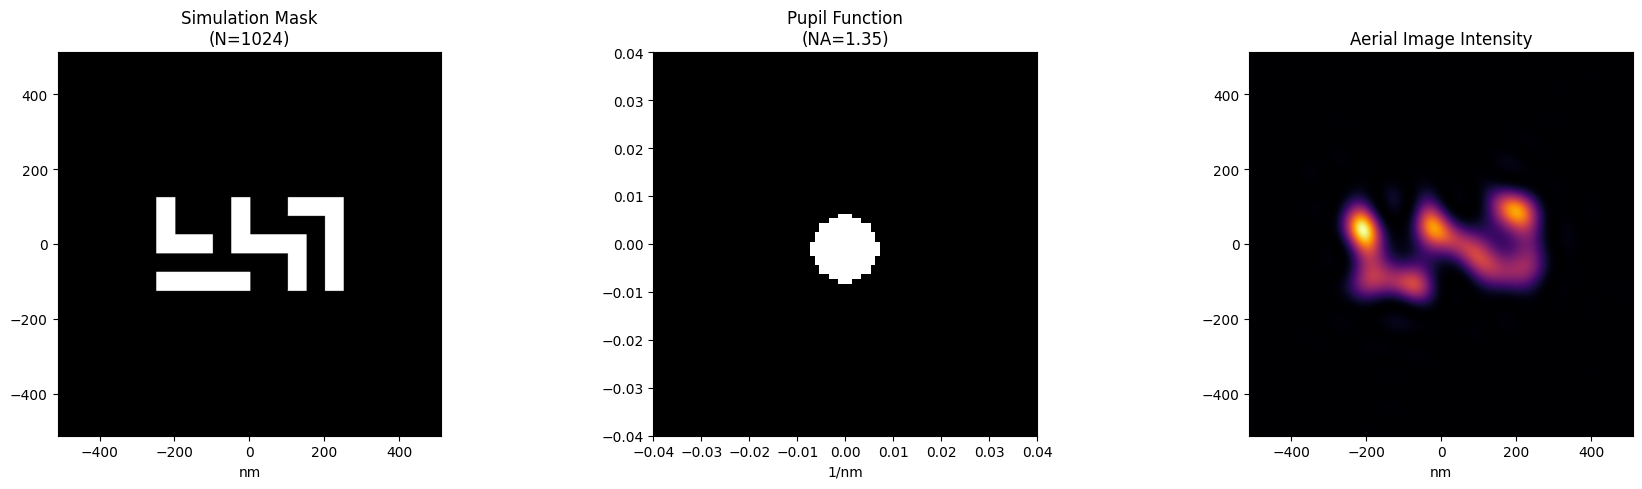

In [165]:
fig, ax = plt.subplots(1, 3, figsize=(18, 5))

# 1 Mask
ax[0].imshow(mask, cmap='gray', origin='lower',  extent=[-L_nm/2, L_nm/2, -L_nm/2, L_nm/2])
ax[0].set_title(f"Simulation Mask\n(N={N_sim})")
ax[0].set_xlabel("nm")

# 2 Pupil (Zoomed in)
# We limit the view because the frequency grid is huge
limit_freq = 0.04 # View range for pupil
ax[1].imshow(np.fft.fftshift(pupil), 
             extent=[np.min(fx), np.max(fx), np.min(fy), np.max(fy)], 
             cmap='gray')
ax[1].set_title(f"Pupil Function\n(NA={NA})")
ax[1].set_xlim([-limit_freq, limit_freq])
ax[1].set_ylim([-limit_freq, limit_freq])
ax[1].set_xlabel("1/nm")

# 3. Aerial Image
ax[2].imshow(intensity, cmap='inferno', extent=[-L_nm/2, L_nm/2, -L_nm/2, L_nm/2], origin='lower')
ax[2].set_title("Aerial Image Intensity")
ax[2].set_xlabel("nm")

plt.tight_layout()
plt.show()

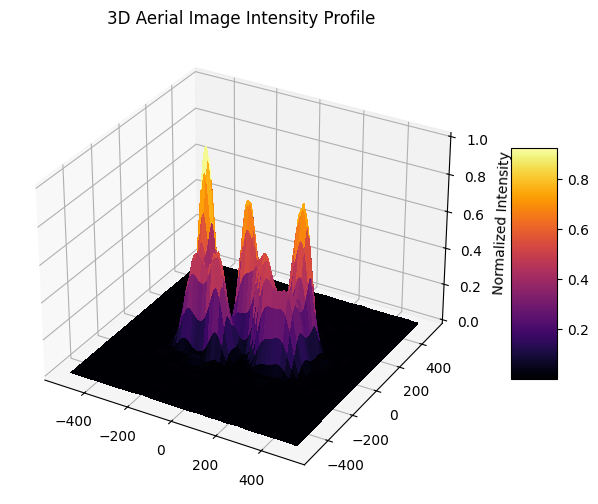

In [166]:
#3d aerial image
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')

# Plot surface
surf = ax.plot_surface(X, Y, intensity, cmap="inferno", linewidth=0, antialiased=False)

ax.set_title("3D Aerial Image Intensity Profile")
ax.set_zlabel("Normalized Intensity")
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()

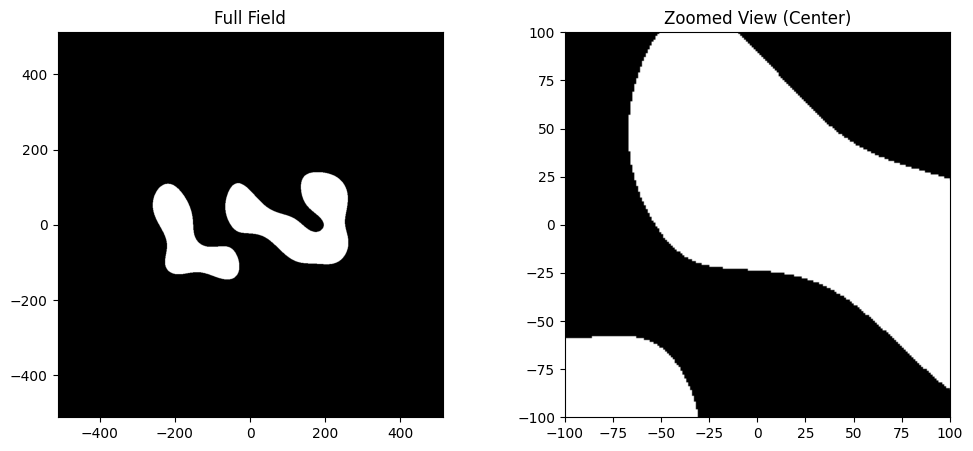

In [177]:
#resist image
resist_threshold = 0.25

resist_img = np.zeros_like(intensity)
resist_img[intensity >= resist_threshold] = 1.0

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
ax1.imshow(resist_img, cmap="gray", extent=[-L_nm/2, L_nm/2, -L_nm/2, L_nm/2], origin='lower')
ax1.set_title("Full Field")

ax2.imshow(resist_img, cmap="gray", extent=[-L_nm/2, L_nm/2, -L_nm/2, L_nm/2], origin='lower')
ax2.set_xlim([-100, 100])
ax2.set_ylim([-100, 100])
ax2.set_title("Zoomed View (Center)")

plt.show()